In [1]:
import numpy as np
import zarr
import matplotlib.pyplot as plt
from tqdm import tqdm
import netCDF4 as nc

In [2]:
import sys
sys.path.insert(0, '/data/SO2/SO24/ANDY/SOHI/Utils')
import Andy

### Modify 700 isobath

In [3]:
bathy = nc.Dataset("/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/Annum/Amundsen.nc")
XC = bathy['lon'][:]
YC = bathy['lat'][:]

bathy, XC, YC = Andy.loads.sohi_meta('bathymetry', lat_bounds = YC, lon_bounds=XC)

In [4]:
mask = np.load('inputs/ref/700m_isobath.npy')

In [5]:
mask2 = mask.copy()

mask2[:, 1008:] = 2 ## From East
mask2[:, :100] = 3 ## From West

mask2[mask==0] = 0

In [6]:
XC[100], XC[1008]

(-135.85416, -98.02081)

In [7]:
np.save('inputs/ref/700m_isobath_v2.npy', mask2)

In [8]:
mask2 = np.load('inputs/ref/700m_isobath_v2.npy')

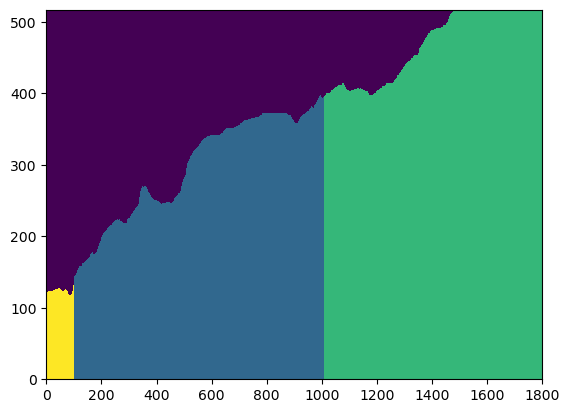

In [9]:
plt.pcolormesh(mask2)

### Find Index of when particle Exit Cavity & Continental Shelf

In [3]:
def extract_index(data_path, CS_mask, nwait = 3):
    
    print('Loading data...')
    
    INDEX = zarr.open(data_path, 'r')
    I = INDEX['I'][:]
    I = I.astype(int)
    J = INDEX['J'][:]
    J = J.astype(int)
    LONGITUDE = INDEX['lon'][:]
    
    IC_mask = np.load('ocean_mask.npy')
    CS_mask = np.load(CS_mask)
    
    
    IC_index = [] ## exit ice cavity 
    Eastern_index = [] ## come from Eastern portion of the shelf 
    Western_index = [] ## come from Western portion of the shelf 
    CS_index = [] ## come from offshelf
    stucked1 = [] ## particles stucked while leaving cavity 
    stucked2 = [] ## particles stucked while leaving continental shelf
    stucked3 = [] ## particles stucked anywhere
    still_in_count = 0
    
    print('Processing...')
    for p in tqdm(range(INDEX['I'].shape[0])):
        added1=False ## Particle exitted ice shelf
        added2=False
        
        fromEW = False
        
        exited = False
        countdown = False
        count = 0
        for t in range(I.shape[1]-4):## No data for last 4 time steps
            i = I[p, t]
            j = J[p, t]
            
            if np.isnan(i) or np.isnan(j):
                break
                
            if not exited: ## particle still under ice shelf 
                
                if IC_mask[i,j] == 1: ## Particle exit ice shelf, start n-day countdown 
                    countdown=True
                    count += 1
                else: ## particle under ice shelf, no active count down 
                    countdown = False
                    count = 0
                    
                if countdown and count == nwait:
                    IC_index.append(t-nwait+1)
                    added1=True
                    exited=True
                    countdown = False

            elif exited: ## Search continental shelf mask
                
                if not fromEW:
                    if CS_mask[i,j] == 2: ## particle touches Eastern portion
                        Eastern_index.append(t)
                        Western_index.append(np.nan)
                        fromEW=True
                    elif CS_mask[i,j] == 3: ## particle touches Western portion
                        Western_index.append(t)
                        Eastern_index.append(np.nan)
                        fromEW=True
                
                if CS_mask[i,j] == 0: ## Particle exit continental shelf, start n-day countdown 
                    countdown=True
                    count += 1
                else: 
                    countdown = False
                    count = 0
                    
                if countdown and count == nwait:
                    CS_index.append(t-nwait+1)
                    added2=True
                    break
                    
 
        if not added1:
            IC_index.append(np.nan)
        if not added2:
            CS_index.append(np.nan)
        if not fromEW:
            Eastern_index.append(np.nan)
            Western_index.append(np.nan)
            
        if added2 or fromEW: ## particle exit ASE - not stuck
            stucked1.append(0)
            stucked2.append(0)
            stucked3.append(0)
            
        elif added1: ## particle exit cavity, but stucked on shelf?
            stucked1.append(0)
            if LONGITUDE[p, -6] == LONGITUDE[p, -5]:
                stucked2.append(1)
                stucked3.append(1)
            else:
                stucked2.append(0)
                stucked3.append(0)
                
        else: ## particle did not exit cavity, stucked?
            if LONGITUDE[p, -6] == LONGITUDE[p, -5]: 
                stucked1.append(1)
                stucked2.append(0)
                stucked3.append(1)
            else:
                stucked1.append(0)
                stucked2.append(0)
                stucked3.append(0)
                still_in_count+= 1
                
#             print(LONGITUDE[p, -6],LONGITUDE[p, -5])
         
    
    print(f"Particles still in cavity after 3 years: {still_in_count}")
    
    return np.asarray(IC_index), np.asarray(CS_index),  np.asarray(Eastern_index), \
np.asarray(Western_index), np.asarray(stucked1), np.asarray(stucked2), np.asarray(stucked3)

In [4]:
test = zarr.open('outputs/R8_ASE_5min/pineisland.zarr', 'r')

In [8]:
IC_index, CS_index, EI, WI, stucked1, stucked2, stucked3 = extract_index(data_path = 'outputs/R8_ASE_5min/pineisland.zarr', 
                                        CS_mask = 'inputs/ref/700m_isobath_v2.npy', 
                                        nwait = 1)

np.save('processed_dataGL/pineisland_0d_IS.npy', IC_index)
np.save('processed_dataGL/pineisland_0d_CS.npy', CS_index)
np.save('processed_dataGL/pineisland_0d_Stucked.npy', stucked3)
np.save('processed_dataGL/pineisland_0d_Stucked_onshelf.npy', stucked2)
np.save('processed_dataGL/pineisland_0d_Stucked_incavity.npy', stucked1)
np.save('processed_dataGL/pineisland_0d_Eastern.npy', EI)
np.save('processed_dataGL/pineisland_0d_Western.npy', WI)

Loading data...
Processing...


100%|███████████████████████████████████████████████████| 397476/397476 [20:35<00:00, 321.84it/s]


Particles still in cavity after 3 years: 1


In [5]:
n = len(IC_index)

v = np.count_nonzero(np.logical_and(~np.isnan(WI), np.isnan(CS_index)))
print(f"Num particles from West ONLY: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(WI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf through West: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(EI), np.isnan(CS_index)))
print(f"Num particles from East ONLY: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(EI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf through East: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(np.isnan(EI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf ONLY: {v} ({v/n*100:0.2f}%)")

Num particles from West ONLY: 2 (0.00%)
Num particles off-shelf through West: 0 (0.00%)
Num particles from East ONLY: 85873 (21.60%)
Num particles off-shelf through East: 12517 (3.15%)
Num particles off-shelf ONLY: 115234 (28.99%)


In [6]:
IC_index, CS_index, EI, WI, stucked1, stucked2, stucked3  = extract_index(data_path = 'outputs/R8_ASE_5min/thwaites.zarr', 
                                        CS_mask = 'inputs/ref/700m_isobath_v2.npy', 
                                        nwait = 1)

np.save('processed_dataGL/thwaites_0d_IS.npy', IC_index)
np.save('processed_dataGL/thwaites_0d_CS.npy', CS_index)
np.save('processed_dataGL/thwaites_0d_Stucked.npy', stucked3)
np.save('processed_dataGL/thwaites_0d_Stucked_onshelf.npy', stucked2)
np.save('processed_dataGL/thwaites_0d_Stucked_incavity.npy', stucked1)
np.save('processed_dataGL/thwaites_0d_Eastern.npy', EI)
np.save('processed_dataGL/thwaites_0d_Western.npy', WI)

Loading data...
Processing...


100%|███████████████████████████████████████████████████| 389790/389790 [19:13<00:00, 337.97it/s]


Particles still in cavity after 3 years: 2


In [7]:
n = len(IC_index)

v = np.count_nonzero(np.logical_and(~np.isnan(WI), np.isnan(CS_index)))
print(f"Num particles from West ONLY: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(WI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf through West: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(EI), np.isnan(CS_index)))
print(f"Num particles from East ONLY: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(EI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf through East: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(np.isnan(EI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf ONLY: {v} ({v/n*100:0.2f}%)")

Num particles from West ONLY: 2 (0.00%)
Num particles off-shelf through West: 0 (0.00%)
Num particles from East ONLY: 78456 (20.13%)
Num particles off-shelf through East: 9622 (2.47%)
Num particles off-shelf ONLY: 104742 (26.87%)


In [8]:
IC_index, CS_index, EI, WI, stucked1, stucked2, stucked3  = extract_index(data_path = 'outputs/R8_ASE_5min/smith.zarr', 
                                        CS_mask = 'inputs/ref/700m_isobath_v2.npy', 
                                        nwait = 1)

np.save('processed_dataGL/smith_0d_IS.npy', IC_index)
np.save('processed_dataGL/smith_0d_CS.npy', CS_index)
np.save('processed_dataGL/smith_0d_Stucked.npy', stucked3)
np.save('processed_dataGL/smith_0d_Stucked_onshelf.npy', stucked2)
np.save('processed_dataGL/smith_0d_Stucked_incavity.npy', stucked1)
np.save('processed_dataGL/smith_0d_Eastern.npy', EI)
np.save('processed_dataGL/smith_0d_Western.npy', WI)

Loading data...
Processing...


100%|███████████████████████████████████████████████████| 376980/376980 [20:25<00:00, 307.52it/s]


Particles still in cavity after 3 years: 20963


In [9]:
n = len(IC_index)

v = np.count_nonzero(np.logical_and(~np.isnan(WI), np.isnan(CS_index)))
print(f"Num particles from West ONLY: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(WI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf through West: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(EI), np.isnan(CS_index)))
print(f"Num particles from East ONLY: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(EI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf through East: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(np.isnan(EI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf ONLY: {v} ({v/n*100:0.2f}%)")

Num particles from West ONLY: 2 (0.00%)
Num particles off-shelf through West: 0 (0.00%)
Num particles from East ONLY: 26459 (7.02%)
Num particles off-shelf through East: 1879 (0.50%)
Num particles off-shelf ONLY: 113652 (30.15%)


In [10]:
IC_index, CS_index, EI, WI, stucked1, stucked2, stucked3  = extract_index(data_path = 'outputs/R8_ASE_5min/kohler.zarr', 
                                        CS_mask = 'inputs/ref/700m_isobath_v2.npy', 
                                        nwait = 1)

np.save('processed_dataGL/kohler_0d_IS.npy', IC_index)
np.save('processed_dataGL/kohler_0d_CS.npy', CS_index)
np.save('processed_dataGL/kohler_0d_Stucked.npy', stucked3)
np.save('processed_dataGL/kohler_0d_Stucked_onshelf.npy', stucked2)
np.save('processed_dataGL/kohler_0d_Stucked_incavity.npy', stucked1)
np.save('processed_dataGL/kohler_0d_Eastern.npy', EI)
np.save('processed_dataGL/kohler_0d_Western.npy', WI)

Loading data...
Processing...


100%|███████████████████████████████████████████████████| 365268/365268 [18:06<00:00, 336.05it/s]


Particles still in cavity after 3 years: 458


In [11]:
n = len(IC_index)

v = np.count_nonzero(np.logical_and(~np.isnan(WI), np.isnan(CS_index)))
print(f"Num particles from West ONLY: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(WI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf through West: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(EI), np.isnan(CS_index)))
print(f"Num particles from East ONLY: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(~np.isnan(EI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf through East: {v} ({v/n*100:0.2f}%)")
v = np.count_nonzero(np.logical_and(np.isnan(EI), ~np.isnan(CS_index)))
print(f"Num particles off-shelf ONLY: {v} ({v/n*100:0.2f}%)")

Num particles from West ONLY: 2 (0.00%)
Num particles off-shelf through West: 0 (0.00%)
Num particles from East ONLY: 16680 (4.57%)
Num particles off-shelf through East: 1045 (0.29%)
Num particles off-shelf ONLY: 148821 (40.74%)
